<h1>Ethical AI</h1>

In [48]:
# ! pip install -U scikit-learn dalex pandas
# ! pip install dalex
# ! pip install aif360 tensorflow

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Question" data-toc-modified-id="Question-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question</a></span></li><li><span><a href="#Dataset-&amp;" data-toc-modified-id="Dataset-&amp;-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset &amp;</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Inprocessing" data-toc-modified-id="Inprocessing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Inprocessing</a></span></li><li><span><a href="#Postprocessing" data-toc-modified-id="Postprocessing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Postprocessing</a></span></li></ul></div>

In [52]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import dalex as dx
import numpy as np
import pandas as pd
import sklearn

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

{"dalex": dx.__version__, "numpy": np.__version__, "pandas": pd.__version__, "sklearn": sklearn.__version__}

{'dalex': '1.4.0', 'numpy': '1.19.5', 'pandas': '1.2.4', 'sklearn': '1.0'}

In [53]:
sklearn.set_config(display="diagram")

## Question

Goal of the project:

Potential biases lie in the genre, age, revenue



## Dataset & 

--> Identi

--> Risk assessment

In [54]:
df, target = dx.datasets.load_german(), "risk"

## EDA
--> Potential bias

In [55]:
def facets(df: pd.DataFrame):
    """ Displays Facets viz
    Source: https://colab.research.google.com/github/PAIR-code/facets/blob/master/colab_facets.ipynb#scrollTo=XtOzRy8Z3M36
    
    Parameters
    ----------
    df: pd.DataFrame
        Data to plot
    """
    from IPython.core.display import display, HTML
    jsonstr = df.to_json(orient='records')
    HTML_TEMPLATE = """
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
            <facets-dive id="elem" height="600"></facets-dive>
            <script>
              var data = {jsonstr};
              document.querySelector("#elem").data = data;
            </script>"""
    html = HTML_TEMPLATE.format(jsonstr=jsonstr)
    display(HTML(html))

In [56]:
facets(df)

## Fairness evaluation of a couple (dataset, model)

<h3> Define and train the model</h3>

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=[target]),
    df[target],
    test_size=0.3,
    random_state=42
)

In [58]:
preprocessor = make_column_transformer(
      (StandardScaler(), make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(), make_column_selector(dtype_include=object))
)


clf_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])
clf_logreg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fadc97c3e50>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fadc97c3ac0>)])),
                ('classifier', LogisticRegression())])

In [59]:
clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fadc97c3e50>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fadc97c3ac0>)])),
                ('classifier', LogisticRegression())])

<h3> Fairness evaluation </h3>

<h4> With dalex </h4>

The main object of dalex is the ```Explainer``` container. It takes as inputs a dataset (features and target) and a trained model. </br>
Once the data and the model has been wrapped, one needs to fix protected and privileged attributes. Beware these choices correspond to an a priori understanding of the problem and could miss hidden flaws of the model. An interesting line of work would consist in conducting a king of grid-search exploration for potential biases.

In [60]:
explainer = dx.Explainer(clf_logreg, X_test, y_test, verbose=False)

protected = X_test.sex + '_' + np.where(X_test.age < 25, 'young', 'old')
privileged = 'male_old'

The method ```model_fairness``` returns a fairness object from which fairness evaluations can be conducted. Notice that every metrics inherited from the confusion matrix are computed during the instantiation. </br>
Two methods can then be performed:
<ul>
    <li> The fairness_check method, which returns a report on the fairness of the model. It requires an epsilon parameter that corresponds to the threshold ratio below which a given metric is considered to be unfair (default value is 0.8).</li>
    <li> The plot method, which allows to visualize the main fairness ratios between the protected subgroups and the privileged one.</li>
</ul>

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male_old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                   TPR       ACC       PPV       FPR       STP
female_old    1.001073  1.099310  1.112011  0.852785  0.984055
female_young  0.843348  0.951724  0.873144  0.530504  0.667426
male_young    0.774678  0.960000  1.170040  0.530504  0.742597


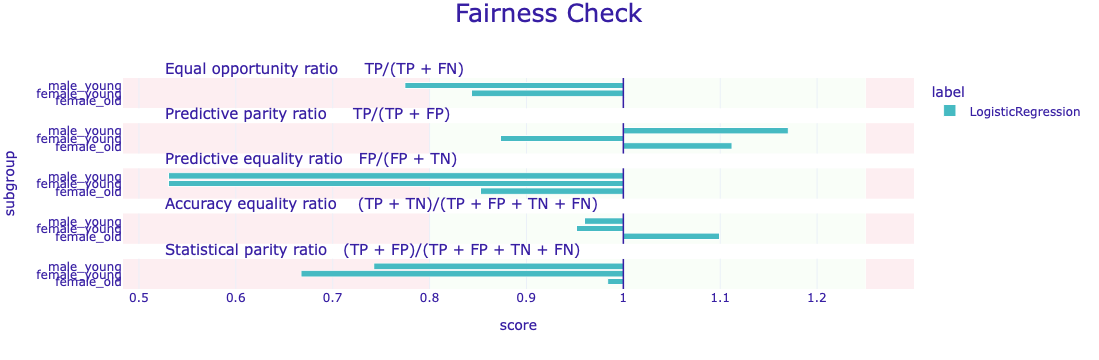

In [61]:
fairness_object = explainer.model_fairness(protected = protected, privileged = privileged)

fairness_object.fairness_check(epsilon = 0.8)
fairness_object.plot()

<h4> With aif360 </h3>

With aif30, there is no such thing as a wrapper of a dataset together with a model. Instead, we need to define two instances of the class ```BinaryLabelDataset```:
<ul>
    <li> One with the groundtruth labels and the protected (resp. privileged) subgroups, </li>
    <li> One with the predicted labels (obtained from a trained model) and the protected (resp. privileged) subgroups.</li>
</ul>
Beware that the data need to be np.arrays.

In [62]:
data_for_aif = X_test[['sex']]
data_for_aif['sex'] = data_for_aif['sex'].apply(lambda x: int(x == 'male'))
data_for_aif['age'] = X_test['age'].apply(lambda x: int(x >= 25))

data_for_aif_gt = data_for_aif.copy()
data_for_aif_gt['risk'] = y_test

data_for_aif_pred = data_for_aif.copy()
data_for_aif_pred['risk'] = clf_logreg.predict(X_test)

binary_dataset_gt = BinaryLabelDataset(df=data_for_aif_gt, label_names=['risk'], protected_attribute_names=['sex', 'age'])
binary_dataset_pred = BinaryLabelDataset(df=data_for_aif_pred, label_names=['risk'], protected_attribute_names=['sex', 'age'])

The two BinaryLabelDataset are then wrapped into a ```ClassificationMetric``` object, which requires to fix privileged and unprivileged subgroups in the form of dictionaries. It seems that, although several groups can be defined, the metrics are only computed for the two first one (an issue of the librabry ?).

In [63]:
aif_classif_metrics = ClassificationMetric(binary_dataset_gt, 
                                           binary_dataset_pred, 
                                           privileged_groups=[{'sex': 1.0, 'age': 1.0}],
                                           unprivileged_groups=[{'sex': 1.0, 'age': 0.0}, {'sex': 0.0, 'age': 1.0}, {'sex': 0.0, 'age': 0.0}]
                                          )

In [64]:
aif_classif_metrics.disparate_impact()

0.8513513513513514

## Preprocessing

## Inprocessing

## Postprocessing